In [ ]:
#@title Mount google drive and git pull
# this cell is to load the google drive to the directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Hpython/noise2pattern
!git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Hpython/noise2pattern
Already up to date.


Use the following commands in the console befor git push to github

`git config --global credential.helper store`

`git pull`

In [ ]:
#@title Parts of the U-Net model
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels // 2, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class Up1(nn.Module):
    """Special version of Up class with only 1 input
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x1 = self.up(x)
        x2 = self.conv(x1)
        return x2


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64 * factor, bilinear)
        self.outc = OutConv(64, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class Up_(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            # self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # self.conv = DoubleConv(in_channels, out_channels // 2, in_channels // 2)
            self.up = nn.ConvTranspose2d(in_channels , in_channels, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels//2, out_channels)

    def forward(self, x):
        x = self.up(x)
        return self.conv(x)


class UNetHalf(nn.Module):   # 1 channel, 16*16
    def __init__(self, n_channels, n_classes, bilinear=False):
        """Only the up part of the unet

        Args:
            n_channels ([type]): [how many input channels=n_sources]
            n_classes ([type]): [how many output classes=n_sources]
            bilinear (bool, optional): [use interpolation or deconv]. Defaults to False(use deconv).
        """
        super(UNetHalf, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 512)
        self.up1 = Up_(512, 256, bilinear)
        self.up2 = Up_(256, 128, bilinear)
        self.up3 = Up_(128, 64, bilinear)
        self.up4 = Up_(64, 32, bilinear)
        self.reshape = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=2),
            nn.ConvTranspose2d(32, 16, kernel_size=5, dilation=3, output_padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(16, 16, kernel_size=3, dilation=3, output_padding=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True)
        )
        self.outc = OutConv(16, n_classes)

    def forward(self, x):
        x = self.inc(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)  # output has W=256, H=256, for gamma = 16
        x = self.reshape(x)
        out = self.outc(x)
        return out


class UNetHalf2(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        """Only the up part of the unet

        Args:
            n_channels ([type]): [how many input channels=n_sources]
            n_classes ([type]): [how many output classes=n_sources]
            bilinear (bool, optional): [use interpolation or deconv]. Defaults to False(use deconv).
        """
        super(UNetHalf2, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.n_ch = 512

        self.inc = DoubleConv(n_channels, self.n_ch)
        self.up1 = Up_(n_channels, self.n_ch//2, bilinear=True)
        self.up2 = Up_(self.n_ch//2, self.n_ch//4, bilinear)
        self.up3 = Up_(self.n_ch//4, self.n_ch//8, bilinear)
        self.up4 = Up_(self.n_ch//8, self.n_ch//16, bilinear)
        self.up5 = Up_(self.n_ch//16, self.n_ch//32, bilinear)
        self.up6 = Up_(self.n_ch//32, self.n_ch//64, bilinear)
        self.up7 = Up_(self.n_ch//64, self.n_ch//128, bilinear)
        self.reshape = nn.Sequential(
            nn.Conv2d(self.n_ch//128, self.n_ch//16, kernel_size=3, padding=1, stride=2),
            nn.ConvTranspose2d(self.n_ch//16, 16, kernel_size=5, dilation=3, output_padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(16, 16, kernel_size=3, dilation=3, output_padding=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True)
        )
        self.outc = OutConv(16, n_classes)

    def forward(self, x):
        # x = self.inc(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)  # output has W=256, H=256, for gamma = 16
        x = self.up5(x) # input has W=32, H=32, for gamma = 2
        x = self.up6(x)
        x = self.up7(x)
        x = self.reshape(x) # input 256 output 150
        out = self.outc(x)
        return out


class UNetHalf64_4(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        """Only the up part of the unet

        Args:
            n_channels ([type]): [how many input channels=n_sources]
            n_classes ([type]): [how many output classes=n_sources]
            bilinear (bool, optional): [use interpolation or deconv]. Defaults to False(use deconv).
        """
        super(UNetHalf64_4, self).__init__()
        self.n_ch = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(self.n_ch, self.n_ch)
        self.up1 = Up_(self.n_ch, self.n_ch//2, bilinear=True)
        self.up2 = Up_(self.n_ch//2, self.n_ch//4, bilinear)
        self.up3 = Up_(self.n_ch//4, self.n_ch//8, bilinear)
        self.up4 = Up_(self.n_ch//8, self.n_ch//16, bilinear)
        self.up5 = Up_(self.n_ch//16, self.n_ch//32, bilinear)
        self.up6 = Up_(self.n_ch//32, self.n_ch//64, bilinear)
        self.reshape = nn.Sequential(
            nn.Conv2d(self.n_ch//64, self.n_ch//16, kernel_size=3, padding=1, stride=2),
            nn.ConvTranspose2d(self.n_ch//16, 16, kernel_size=5, dilation=3, output_padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(16, 16, kernel_size=3, dilation=3, output_padding=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True)
        )
        self.outc = OutConv(16, n_classes)

    def forward(self, x):
        x = self.inc(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)  # output has W=256, H=256, for gamma = 16
        x = self.up5(x) # input has W=32, H=32, for gamma = 2
        x = self.up6(x)
        x = self.reshape(x) # input 256 output 150
        out = self.outc(x)
        return out


In [ ]:
#@title Loading packages
!pip install torch_optimizer
import os
import h5py 
import numpy as np
import scipy.io as sio
from scipy.signal import stft 
import itertools

import torch
from torch import nn
import torch.nn.functional as Func
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
plt.rcParams['figure.dpi'] = 100

# from unet.unet_model import UNet

"make the result reproducible"
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#@title Load data

# %% toy experiment 3
"""only generate 1-class vj and let it move. Also train only one neural network to see if it could capture
the patter
"""
from utils import *
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#%% load options for training 
opts = {}
opts['n_epochs'] = 200  
opts['lr'] = 0.01
opts['n_batch'] = 64  # batch size
opts['d_gamma'] = 2 # gamma dimesion 16*16 to 200*200

# %% load data
from PIL import Image  # install Pillow
d = Image.open('../data/vj3.png')
d = np.array(d)
d = torch.tensor(1-d[...,0]/255).float()

# row 44 has 1, column 47 has 1
F, T = d.shape
N = 10000
data = torch.zeros(N, F, T)
n = 0
for r in range(105):
    for c in range(102):
        if n < N:
            data[n] = torch.roll(d, (r, c), (0, 1))
            n += 1
gamma = torch.rand(N, opts['d_gamma'])
" wrap as data loader"
ind = torch.randperm(N)
gamma, data = gamma[ind], data[ind]
data = Data.TensorDataset(gamma[:3000], data[:3000])
tr = Data.DataLoader(data, batch_size=opts['n_batch'], shuffle=False, drop_last=True)


In [ ]:
#@title Train
#%% set neural networks
model = UNetHalf(n_channels=1, n_classes=1).cuda()
optimizer = optim.RAdam(model.parameters(),
                lr= opts['lr'],
                betas=(0.9, 0.999),
                eps=1e-8,
                weight_decay=0)
for param in model.parameters():
    param.requires_grad_(False)
loss_cv = []

for epoch in range(1):    
    for i, (gamma, v) in enumerate(tr): # gamma [n_batch, n_f, n_t]
        x = gamma[:,None].cuda().requires_grad_()
        v = v[:,None].cuda()

        # "update gamma"
        # optim_gamma = torch.optim.SGD([x], lr= opts['lr'])  # every iter the gamma grad is reset
        # out = model(x.diag_embed())
        # loss = ((out - v)**2).sum()/opts['n_batch']
        # optim_gamma.zero_grad()   
        # loss.backward()
        # torch.nn.utils.clip_grad_norm_([x], max_norm=500)
        # optim_gamma.step()
        # torch.cuda.empty_cache()

        # "update model"
        # for param in model.parameters():
        #     param.requires_grad_(True)
        # x.requires_grad_(False)
        # out = model(x.diag_embed())
        # loss = ((out - v)**2).sum()/opts['n_batch']
        # optimizer.zero_grad()   
        # loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=500)
        # optimizer.step()
        # torch.cuda.empty_cache()

        # loss_cv.append(loss.detach().item())
    
    if epoch%1 ==0:
        plt.figure()
        plt.semilogy(loss_cv, '--xr')
        plt.title('val loss per epoch')
        plt.show()

        plt.figure()
        plt.imshow(out[0,0].detach().cpu())
        plt.show()

        plt.figure()
        plt.imshow(v[0,0].detach().cpu())
        plt.title('Ground Truth')
        plt.show()

        # torch.save([model, epoch], 'model_epoch.pt')


In [ ]:
a = torch.rand(10).cuda()


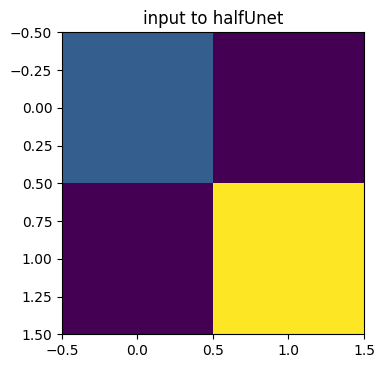

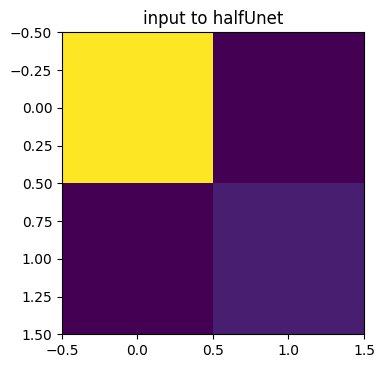

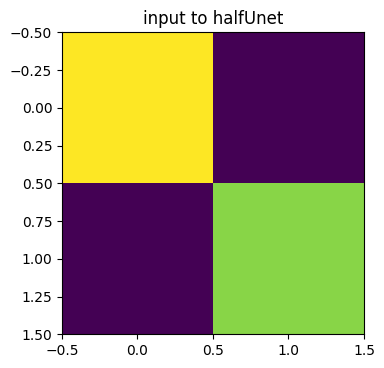

In [ ]:
for i in [1,30, 50]:
    plt.figure()
    plt.imshow(x[i,0].detach().cpu().diag_embed())
    plt.title('input to halfUnet')
    plt.show()

In [ ]:
#@title Play
M,N,F,J = 5, 50, 50, 3
theta = np.array([213, 58, 35])*np.pi/180
h = np.exp(-1j*np.pi*np.arange(0,M)[:,None]@ np.sin(theta)[None, :]);
randn = np.random.randn

v1 = np.random.rand(N,F,J).astype(np.cfloat);
s = np.zeros([N,F,J], dtype=np.cfloat);
c = np.zeros([M,N,F,J], dtype=np.cfloat);
for j in range(J):
    s[:,:,j] = (randn(N,F)+1j*randn(N,F))/np.sqrt(2)*np.sqrt(v1[:,:,j]);
    for m in range(M):
        c[m,:,:,j] = h[m,j]*s[:,:,j];

x = np.sum(c,-1) + (randn(M,N,F)+1j*randn(M,N,F))/np.sqrt(2)*np.sqrt(1e-10)  #M x N x F

# to pytorch
x = torch.tensor(x, dtype=torch.cfloat).permute(1,2,0)[...,None]  # N, F, M, 1
s = torch.tensor(s, dtype=torch.cfloat)[...,None]  # N, F, J,1
H = torch.tensor(h, dtype=torch.cfloat) # M, J
Rs = torch.tensor(v1, dtype=torch.cfloat).diag_embed() # N, F, J, J
Rb = 2*1e-10*torch.ones(N, F, M, dtype=torch.cfloat).diag_embed()  #N,F,M, M
Rx = H@(Rs@H.conj().t()) + Rb # N, F, M, M
